In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

Для начала хочу сгенерировать 10000 строк исторических данных, состоящих из колонок город, класс(стандарт,комфорт,бизнес), модекс/нет, тип недвижимости(квартира/коттедж/офис) и комнатность

Зададим так, что в Астане реализуется 40% объектов, в Алматы - 25, на Юге - 20, на западе -10 и за рубежом - 5.
40% всех объектов класса Стандарт, 40 - класса комфорт и 20 класса бизнес.
20% - модекс, 80% нет.
80% - кватиры, по 10 коттеджи и офисы.
25% 1-комнатные, 30% - 2х, 25% - 3х, 15% - 4х и 5% пятикомнатные.
Количество дней за сколько продается объект сгенерируем так, что в первые 30% интервала продается 60% объектов

In [144]:
columns = ['city', 'class', 'is_modex', 'room_type', 'rooms_count','days_to_be_sold']
cities = ['Астана', 'Алматы', 'Юг', 'Запад','Зарубеж']
cities_probs = [0.4, 0.25, 0.2, 0.10,0.05]  # Вероятности для каждого города

classes = ['Стандарт', 'Комфорт', 'Бизнес']
classes_probs = [0.4, 0.4, 0.2]  # Вероятности для каждого класса жилья

is_modex = ['True','False']
is_modex_probs = [0.2,0.8]  # modex или нет

room_types = ['Квартира','Коттедж','Офис'] #тип недвижимости
room_type_probs = [0.8,0.1,0.1]

room_count = [1,2,3,4,5] #комнатность
room_count_probs = [0.25,0.3,0.25,0.15,0.05]

days_to_be_sold = range(0,1000) #на какой день со старта продаж продалось
days_to_be_sold_probs = [0.6 / 300] * 300 + [0.4 / 700] * 700 #задал так, что в первые 30% интервала продается 60% объектов


def get_random_values(n):
    return {
        'city': np.random.choice(cities, n, p=cities_probs),
        'class': np.random.choice(classes, n, p=classes_probs),
        'is_modex': np.random.choice(is_modex, n, p=is_modex_probs),
        'room_type': np.random.choice(room_types, n, p=room_type_probs),
        'rooms_count': np.random.choice(room_count, n, p=room_count_probs),
        'days_to_be_sold': np.random.choice(days_to_be_sold, n, p=days_to_be_sold_probs)
    }

num_rows = 10000

random_values = get_random_values(num_rows)
historic_data = pd.DataFrame(random_values, columns=columns)
historic_data

,city,class,is_modex,room_type,rooms_count,days_to_be_sold
0,Астана,Комфорт,False,Квартира,1,869
1,Алматы,Комфорт,False,Квартира,1,893
2,Астана,Стандарт,False,Квартира,1,691
3,Алматы,Бизнес,False,Офис,2,267
4,Юг,Стандарт,False,Квартира,1,331
...,...,...,...,...,...,...
9995,Астана,Бизнес,False,Квартира,2,213
9996,Астана,Комфорт,False,Квартира,4,279
9997,Астана,Стандарт,False,Квартира,2,580
9998,Астана,Комфорт,False,Квартира,3,728


Сгенерировал исторические данные из 10 000 строк

Проверим распределения каждой колонки

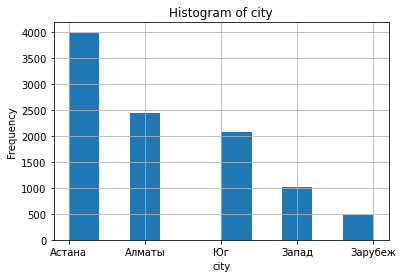

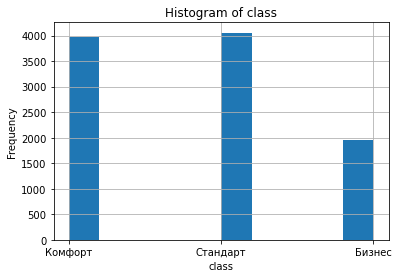

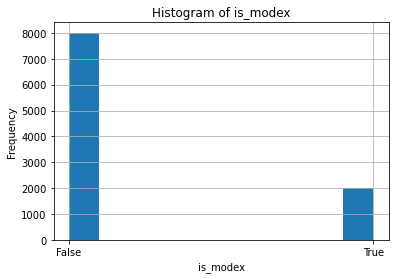

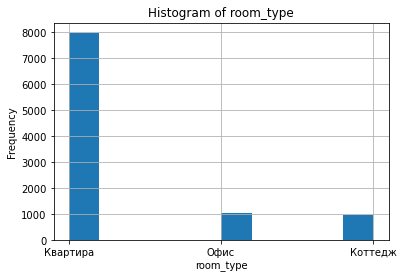

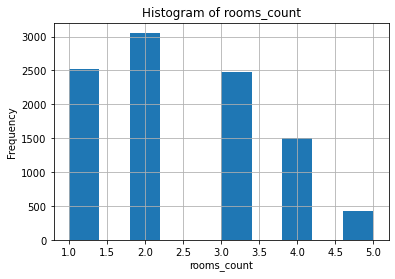

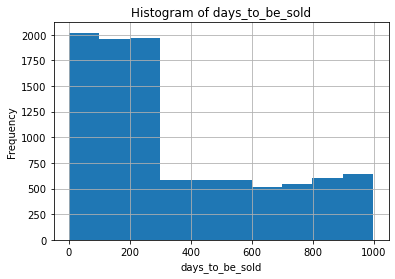

In [145]:
for col in historic_data.columns:
    plt.figure()  # Создаем новую фигуру
    historic_data[col].hist()
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Визуально проверили на реалистичность

Давайте проверим графики продаж по месяцам от 1-го до 18-го месяца, с учетом того, что  основные продажи реализуются в первой временной половине 

Напишем функцию для графика куммулятивной продаваемости объектов за 18 месяцев  

In [146]:
def show_the_sales_graph_accumilated(df):
    column_sums = df[df.columns.tolist()].sum()
    plt.figure(figsize=(10, 6))
    plt.bar(column_sums.index, column_sums.values)
    plt.xlabel('Кол-во месяцев')
    plt.ylabel('Продано объектов')
    plt.title('График продаж аккумулированный')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Добавим колонки, показывающие статус проданности объекта за периоды от 1 до 18 месяцев, где 1-объект продан, 0 - нет

In [147]:
for i in range(1,19):
    historic_data[f'sold after {i} monthes'] = (30*i> historic_data['days_to_be_sold']).astype(int)
historic_data.head()

,city,class,is_modex,room_type,rooms_count,days_to_be_sold,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,sold after 4 monthes,...,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
0,Астана,Комфорт,False,Квартира,1,869,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Алматы,Комфорт,False,Квартира,1,893,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Астана,Стандарт,False,Квартира,1,691,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Алматы,Бизнес,False,Офис,2,267,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,Юг,Стандарт,False,Квартира,1,331,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1


Проверим как влияет на продаваемость каждый из параметров

In [149]:
columns_paramerets = historic_data.columns.tolist()[0:5]
for col in columns_paramerets:
    sales_by_classes = historic_data.groupby(col).agg({'sold after 6 monthes': lambda x:x.sum()/x.count(),'sold after 12 monthes': lambda x:x.sum()/x.count(),'sold after 18 monthes': lambda x:x.sum()/x.count()})
    sales_by_classes.reset_index(inplace=True)
    display(sales_by_classes)

,city,sold after 6 monthes,sold after 12 monthes,sold after 18 monthes
0,Алматы,0.366954,0.640836,0.746617
1,Астана,0.349135,0.627038,0.735390
2,Запад,0.388119,0.635644,0.744554
3,Зарубеж,0.371901,0.628099,0.731405
4,Юг,0.343750,0.610096,0.720192


,class,sold after 6 monthes,sold after 12 monthes,sold after 18 monthes
0,Бизнес,0.361691,0.622517,0.731533
1,Комфорт,0.344135,0.621452,0.729214
2,Стандарт,0.368343,0.636588,0.744083


,is_modex,sold after 6 monthes,sold after 12 monthes,sold after 18 monthes
0,False,0.355947,0.626062,0.734008
1,True,0.363226,0.634770,0.742485


,room_type,sold after 6 monthes,sold after 12 monthes,sold after 18 monthes
0,Квартира,0.351619,0.620261,0.729224
1,Коттедж,0.387940,0.661307,0.754774
2,Офис,0.372474,0.653513,0.767084


,rooms_count,sold after 6 monthes,sold after 12 monthes,sold after 18 monthes
0,1,0.352895,0.631642,0.742268
1,2,0.355432,0.627831,0.730226
2,3,0.363966,0.627973,0.739218
3,4,0.358466,0.628307,0.736772
4,5,0.356164,0.602740,0.712329


Так как в генераторе исходных данных я не задавал никаких долей или весов для параметров, у всех показывает равномерные показатели. На реальных данных можно будет на это взглянуть

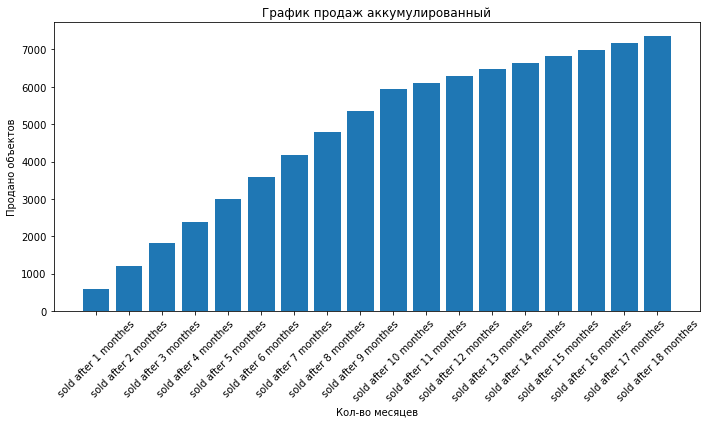

In [150]:
show_the_sales_graph_accumilated(historic_data[historic_data.columns.tolist()[6::]])

Напишем функцию для графика продаж по месяцам без аккумуляции

In [151]:
def show_the_sales_graph_by_month(df):
    sums = df.sum()
    differences = [sums[0]]+[sums[i + 1] - sums[i] for i in range(len(sums) - 1)]
    monthes=[i for i in range(1,19)]
    plt.figure(figsize=(10, 6))
    plt.bar(monthes, differences)
    plt.title('Продажи по каждому месяцу')
    plt.xlabel('Месяцы со старта продаж')
    plt.ylabel('Продано объектов')
    plt.show()

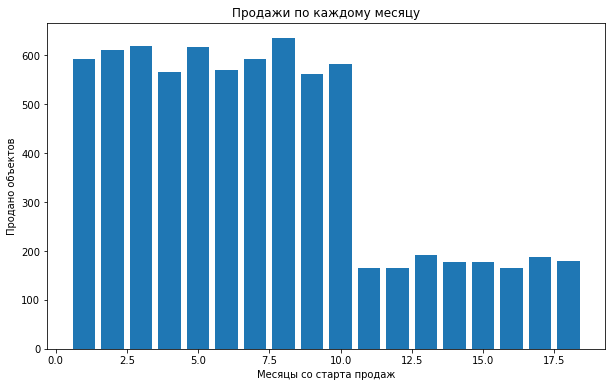

In [152]:
show_the_sales_graph_by_month(historic_data[historic_data.columns.tolist()[6::]])

Как видим, генератор правильно понял логику, что в основные продажи в первой части срока

Теперь сгенерируем параметры объектов, которые еще в проекте и попробуем предсказать на них графики продаж и сравним их и графиками исторических данных

In [153]:
columns = ['city', 'class', 'is_modex', 'room_type', 'rooms_count']
cities = ['Астана', 'Алматы', 'Юг', 'Запад','Зарубеж']
cities_probs = [0.4, 0.25, 0.2, 0.10,0.05]  # Вероятности для каждого города

classes = ['Стандарт', 'Комфорт', 'Бизнес']
classes_probs = [0.4, 0.4, 0.2]  # Вероятности для каждого класса жилья

is_modex = ['True','False']
is_modex_probs = [0.2,0.8]  # modex или нет

room_types = ['Квартира','Коттедж','Офис'] #тип недвижимости
room_type_probs = [0.8,0.1,0.1]

room_count = [1,2,3,4,5] #комнатность
room_count_probs = [0.25,0.3,0.25,0.15,0.05]

def get_random_values(n):
    return {
        'city': np.random.choice(cities, n, p=cities_probs),
        'class': np.random.choice(classes, n, p=classes_probs),
        'is_modex': np.random.choice(is_modex, n, p=is_modex_probs),
        'room_type': np.random.choice(room_types, n, p=room_type_probs),
        'rooms_count': np.random.choice(room_count, n, p=room_count_probs),
    }

num_rows = 1000

random_values = get_random_values(num_rows)
not_started = pd.DataFrame(random_values, columns=columns)
not_started

,city,class,is_modex,room_type,rooms_count
0,Астана,Стандарт,False,Квартира,2
1,Астана,Комфорт,False,Квартира,1
2,Алматы,Комфорт,False,Квартира,2
3,Юг,Стандарт,False,Квартира,2
4,Юг,Стандарт,False,Квартира,3
...,...,...,...,...,...
995,Алматы,Комфорт,False,Квартира,4
996,Юг,Комфорт,True,Квартира,3
997,Астана,Комфорт,False,Квартира,3
998,Юг,Стандарт,False,Квартира,5


Сгенерировали 1000 строк для квартир, старт продаж которых еще не начался

Натренируем на исторических данных и предскажем значения для 18 колонок, статусов продаж по месяцам

In [154]:
columnsX=historic_data.columns.tolist()[0:5]
columnsy=historic_data.columns.tolist()[6::]

In [155]:
X = historic_data[columnsX]
Y = historic_data[columnsy]
X = pd.get_dummies(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
linear_regressor = LinearRegression()
multi_target_regressor = MultiOutputRegressor(linear_regressor)
multi_target_regressor.fit(X_train, Y_train)

Y_test_pred = multi_target_regressor.predict(X_test)
test_mse = mean_squared_error(Y_test, Y_test_pred, multioutput='uniform_average')
print(f"Mean Squared Error on test data: {test_mse}")

Y_train_pred = multi_target_regressor.predict(X_train)
train_mse = mean_squared_error(Y_train, Y_train_pred, multioutput='uniform_average')
print(f"Mean Squared Error on train data: {train_mse}")

Mean Squared Error on test data: 0.20449628963938468
Mean Squared Error on train data: 0.20271851306741295


mean squared error - 0.2 и почти одинаковый на тренировочных и тестовых данных. Значит модель не перетренирована.

с помощью модели предскажем статус проданности для 18 месяцев 

In [156]:
not_started = pd.get_dummies(not_started)
not_started_predictions = multi_target_regressor.predict(not_started)
not_started_predictions = pd.DataFrame(not_started_predictions, columns=columnsy)
not_started_predictions

,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,sold after 4 monthes,sold after 5 monthes,sold after 6 monthes,sold after 7 monthes,sold after 8 monthes,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
0,0.064573,0.120570,0.184923,0.239409,0.297879,0.353082,0.417461,0.478764,0.537016,0.585589,0.603361,0.622888,0.642100,0.657349,0.677130,0.692263,0.709692,0.731570
1,0.057541,0.112417,0.159528,0.203290,0.262656,0.319268,0.378052,0.444661,0.513831,0.565765,0.588341,0.603107,0.624480,0.640961,0.657768,0.677402,0.696499,0.718412
2,0.055023,0.116106,0.170330,0.231284,0.286794,0.345251,0.401970,0.474121,0.532991,0.587270,0.608438,0.625903,0.645034,0.666469,0.685544,0.703522,0.721837,0.736080
3,0.057204,0.114259,0.184223,0.234223,0.284740,0.348628,0.408418,0.467034,0.519329,0.579621,0.594888,0.614105,0.631444,0.650698,0.673231,0.687735,0.700696,0.721500
4,0.058518,0.116322,0.187046,0.241005,0.290280,0.351270,0.408369,0.470366,0.519543,0.578656,0.592383,0.613058,0.628655,0.649230,0.671735,0.685249,0.698541,0.719345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.057652,0.120231,0.175977,0.244849,0.297875,0.350535,0.401871,0.480786,0.533419,0.585340,0.603428,0.623808,0.639455,0.663533,0.682553,0.698549,0.717527,0.731769
996,0.043052,0.104670,0.164100,0.210418,0.263114,0.328106,0.374806,0.443736,0.505200,0.565174,0.585319,0.604508,0.624547,0.643707,0.655126,0.680852,0.697472,0.717122
997,0.060170,0.116543,0.165175,0.216855,0.273738,0.324552,0.377952,0.451326,0.514259,0.563835,0.583332,0.601012,0.618902,0.638025,0.654777,0.672429,0.692189,0.714102
998,0.061147,0.120447,0.192693,0.254569,0.301361,0.356554,0.408270,0.477032,0.519971,0.576727,0.587373,0.610963,0.623077,0.646294,0.668744,0.680276,0.694231,0.715034


Визуализируем аккумулированный и месячный графики продаж

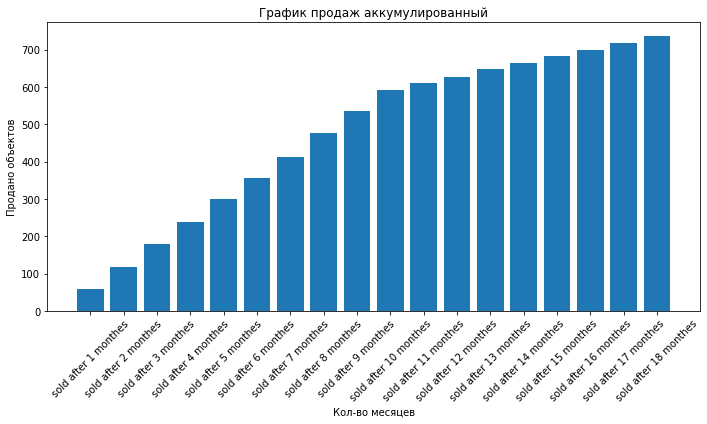

In [157]:
show_the_sales_graph_accumilated(not_started_predictions)

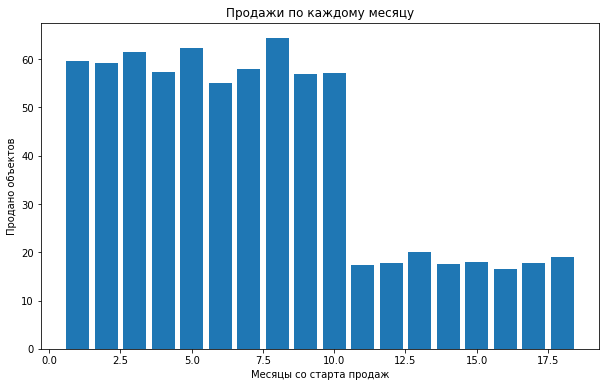

In [158]:
show_the_sales_graph_by_month(not_started_predictions)

Графики очень похожи на графики исторических данных

Вторая часть задачи. 
- Есть жк комфорт класса, со старта продаж прошло 8 месяцев и есть данные и продажах
- Построим план продаж оставшихся 10 месяцев на основе 8 месяцев этого жк и исторических данных.
- Предположим, что прошел еще месяц и есть новые данные, тогда добавим его в факт и  скорректируем план продаж на оставшиеся 9 месяцев

Идея состоит в том,чтобы вывести проценты продаваемости индивидально для каждой группы объектов по набору типов город-класс-модекс/нет-тип недвижимости-кол-во  комнат.

In [159]:
result = historic_data.groupby(['city', 'class', 'is_modex', 'room_type', 'rooms_count']).agg({
    'sold after 1 monthes': lambda x:x.sum()/x.count(),
    'sold after 2 monthes': lambda x:x.sum()/x.count(),
    'sold after 3 monthes': lambda x:x.sum()/x.count(),
    'sold after 4 monthes': lambda x:x.sum()/x.count(),
    'sold after 5 monthes': lambda x:x.sum()/x.count(),
    'sold after 6 monthes': lambda x:x.sum()/x.count(),
    'sold after 7 monthes': lambda x:x.sum()/x.count(),
    'sold after 8 monthes': lambda x:x.sum()/x.count(),
    'sold after 9 monthes': lambda x:x.sum()/x.count(),
    'sold after 10 monthes': lambda x:x.sum()/x.count(),
    'sold after 11 monthes': lambda x:x.sum()/x.count(),
    'sold after 12 monthes': lambda x:x.sum()/x.count(),
    'sold after 13 monthes': lambda x:x.sum()/x.count(),
    'sold after 14 monthes': lambda x:x.sum()/x.count(),
    'sold after 15 monthes': lambda x:x.sum()/x.count(),
    'sold after 16 monthes': lambda x:x.sum()/x.count(),
    'sold after 17 monthes': lambda x:x.sum()/x.count(),
    'sold after 18 monthes': lambda x:x.sum()/x.count()
    }).reset_index()

In [160]:
result[(result['city']=='Астана')&(result['class']=='Комфорт')].head()

,city,class,is_modex,room_type,rooms_count,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,sold after 4 monthes,sold after 5 monthes,...,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
114,Астана,Комфорт,False,Квартира,1,0.061818,0.116364,0.167273,0.225455,0.312727,...,0.578182,0.621818,0.647273,0.658182,0.680000,0.694545,0.723636,0.738182,0.745455,0.763636
115,Астана,Комфорт,False,Квартира,2,0.041096,0.085616,0.136986,0.181507,0.256849,...,0.523973,0.592466,0.609589,0.623288,0.643836,0.650685,0.660959,0.678082,0.691781,0.722603
116,Астана,Комфорт,False,Квартира,3,0.087452,0.129278,0.190114,0.250951,0.315589,...,0.555133,0.612167,0.619772,0.631179,0.646388,0.676806,0.692015,0.703422,0.718631,0.730038
117,Астана,Комфорт,False,Квартира,4,0.064935,0.149351,0.181818,0.227273,0.259740,...,0.461039,0.512987,0.538961,0.558442,0.564935,0.584416,0.610390,0.623377,0.636364,0.662338
118,Астана,Комфорт,False,Квартира,5,0.031250,0.062500,0.125000,0.156250,0.218750,...,0.468750,0.531250,0.531250,0.562500,0.593750,0.625000,0.625000,0.656250,0.750000,0.750000


In [164]:
historic_sales_rate_list = [result[col].mean() for col in columns_1_to_18]
historic_sales_rate = pd.DataFrame([historic_sales_rate_list], columns=columns_1_to_18)
historic_sales_rate

,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,sold after 4 monthes,sold after 5 monthes,sold after 6 monthes,sold after 7 monthes,sold after 8 monthes,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
0,0.064064,0.134401,0.197168,0.257201,0.327727,0.386709,0.438489,0.494763,0.547238,0.611691,0.62408,0.640688,0.659876,0.68202,0.69405,0.716523,0.736319,0.75181


Так как в сгенерированных тестовых данных все планы по всем видам разбиений по типам ровномеры, в конретной задаче решил взять единый график коэффициентов продаваемости по месяцам

Моделирум ситуацию ЖК "take_home",  с разным количеством разнокомнатных квартир, и с каким-то количеством проданных.

In [194]:
data = {
    'Комнатность': ['1-комн', '2-комн', '3-комн', '4-комн', '5-комн'],
    'Количество квартир':[150,170,100,50,30],
    'Продано за 8 месяцев, факт': [65,84,35,15,12],
    'Продано за 8 месяцев, план': [np.nan] * 5
}
take_home = pd.DataFrame(data)
take_home['Продано за 8 месяцев, план'] = take_home['Количество квартир']*historic_sales_rate.at[0,'sold after 8 monthes']

take_home

,Комнатность,Количество квартир,"Продано за 8 месяцев, факт","Продано за 8 месяцев, план"
0,1-комн,150,65,74.214466
1,2-комн,170,84,84.109728
2,3-комн,100,35,49.476311
3,4-комн,50,15,24.738155
4,5-комн,30,12,14.842893


Посчитаем отставание от плана по каждому типу

In [167]:
take_home['Отставание'] = take_home['Продано за 8 месяцев, план'] - take_home['Продано за 8 месяцев, факт']
take_home['Отставание'] = take_home['Отставание'].apply(lambda x: max(x, 0))
take_home

,Комнатность,Количество квартир,"Продано за 8 месяцев, факт","Продано за 8 месяцев, план",Отставание
0,1-комн,150,65,72.23835,7.23835
1,2-комн,170,84,81.87013,0.00000
2,3-комн,100,35,48.15890,13.15890
3,4-комн,50,15,24.07945,9.07945
4,5-комн,30,12,14.44767,2.44767


Как видно, по четырем из пяти квартир есть отставания от планов продаж от исторического графика. Идея состоит в том, чтобы распределить эти отставания равномерно на осташеися 10 месяцев и получить новый план продаж

In [168]:
historic_sales_rate_from_9 = historic_sales_rate[historic_sales_rate.columns.tolist()[8::]]
coefficients = historic_sales_rate_from_9.iloc[0].tolist()
for i in range(9,19):
    take_home[f'План продаж за {i} месяцев'] = take_home['Количество квартир']*coefficients[i-9]+take_home['Отставание']/10
take_home

,Комнатность,Количество квартир,"Продано за 8 месяцев, факт","Продано за 8 месяцев, план",Отставание,План продаж за 9 месяцев,План продаж за 10 месяцев,План продаж за 11 месяцев,План продаж за 12 месяцев,План продаж за 13 месяцев,План продаж за 14 месяцев,План продаж за 15 месяцев,План продаж за 16 месяцев,План продаж за 17 месяцев,План продаж за 18 месяцев
0,1-комн,150,65,72.23835,7.23835,82.809489,92.477478,94.335906,96.826971,99.705229,103.026875,104.831283,108.202284,111.171727,113.495290
1,2-комн,170,84,81.87013,0.00000,93.030407,103.987462,106.093680,108.916887,112.178914,115.943445,117.988441,121.808909,125.174278,127.807649
2,3-комн,100,35,48.15890,13.15890,56.039659,62.484985,63.723937,65.384647,67.303486,69.517917,70.720855,72.968189,74.947818,76.496860
3,4-комн,50,15,24.07945,9.07945,28.269830,31.492493,32.111969,32.942324,33.901743,35.008958,35.610428,36.734095,37.723909,38.498430
4,5-комн,30,12,14.44767,2.44767,16.661898,18.595496,18.967181,19.465394,20.041046,20.705375,21.066257,21.740457,22.334345,22.799058


Распределив отставания по каждому типу линейно равномерно на оставшиеся месяцы получаем новый план продаж

### Завершаю эту часть решения. В подходе решения наложил следующее ограничение - взял средние вероятности продаж по всем строкам по каждому месяцу, то есть туда вошли все вариванты по всем пяти параметрам (город,класс,модекс,тип,комнатность). Так как в тестовом задании достаточно показать ход решения то если представить, что сумма этих верояносией и есть доля проданных объектов на момент времени - то можно считать задачу решенной

## Теперь попробую высчитать по доле распроданных квартир в объекте

In [1]:
def create_sample_project(i,j,k):
    columns = ['city', 'class', 'is_modex', 'room_type', 'rooms_count','days_to_be_sold']
    cities = [i]
    cities_probs = [1]  # Вероятности для каждого города

    classes = [j]
    classes_probs = [1]  # Вероятности для каждого класса жилья

    is_modex = [k]
    is_modex_probs = [1]  # modex или нет

    room_types = ['Квартира','Коттедж','Офис'] #тип недвижимости
    room_type_probs = [0.8,0.1,0.1]

    room_count = [1,2,3,4,5] #комнатность
    room_count_probs = [0.25,0.3,0.25,0.15,0.05]

    days_to_be_sold = range(0,1000) #на какой день со старта продаж продалось
    days_to_be_sold_probs = [0.6 / 300] * 300 + [0.4 / 700] * 700 #задал так, что в первые 30% интервала продается 60% объектов

    def get_random_values(n):
        return {
            'city': np.random.choice(cities, n, p=cities_probs),
            'class': np.random.choice(classes, n, p=classes_probs),
            'is_modex': np.random.choice(is_modex, n, p=is_modex_probs),
            'room_type': np.random.choice(room_types, n, p=room_type_probs),
            'rooms_count': np.random.choice(room_count, n, p=room_count_probs),
            'days_to_be_sold': np.random.choice(days_to_be_sold, n, p=days_to_be_sold_probs)
        }
    
    
    num_rows = 500

    random_values = get_random_values(num_rows)
    sample_current_project = pd.DataFrame(random_values, columns=columns)
        
    return sample_current_project

In [182]:
sample_projects=[]
number=1
for i in ['Астана','Алматы','Юг']:
    for j in ['Стандарт','Комфорт','Бизнес']:
        for k in [True,False]:
            sample_project = create_sample_project(i,j,k)
            sample_project['id_проекта']=number
            sample_projects.append(sample_project)
            number+=1
combined_sample_projects_current = pd.concat(sample_projects, ignore_index=True)
combined_sample_projects_current

,city,class,is_modex,room_type,rooms_count,days_to_be_sold,id_проекта
0,Астана,Стандарт,True,Квартира,5,69,1
1,Астана,Стандарт,True,Квартира,3,22,1
2,Астана,Стандарт,True,Квартира,3,367,1
3,Астана,Стандарт,True,Квартира,4,228,1
4,Астана,Стандарт,True,Квартира,1,220,1
...,...,...,...,...,...,...,...
8995,Юг,Бизнес,False,Квартира,3,237,18
8996,Юг,Бизнес,False,Квартира,2,281,18
8997,Юг,Бизнес,False,Квартира,2,226,18
8998,Юг,Бизнес,False,Квартира,2,217,18


Сгенерировал 18 текущих проектов

Сгенерируем заново исторические данные чтобы был id проекта

In [183]:
cities = ['Астана'] * 5 + ['Алматы'] * 4 + ['Юг'] * 3 + ['Запад']*2 + ['Зарубеж']
sample_projects=[]
number=1
for i in cities:
    for j in ['Стандарт','Комфорт','Бизнес']:
        for k in [True,False]:
            sample_project = create_sample_project(i,j,k)
            sample_project['id_проекта']=number
            sample_projects.append(sample_project)
            number+=1
combined_sample_projects_historic = pd.concat(sample_projects, ignore_index=True)
combined_sample_projects_historic

,city,class,is_modex,room_type,rooms_count,days_to_be_sold,id_проекта
0,Астана,Стандарт,True,Коттедж,4,281,1
1,Астана,Стандарт,True,Квартира,2,356,1
2,Астана,Стандарт,True,Квартира,1,523,1
3,Астана,Стандарт,True,Квартира,4,90,1
4,Астана,Стандарт,True,Квартира,3,205,1
...,...,...,...,...,...,...,...
44995,Зарубеж,Бизнес,False,Квартира,5,215,90
44996,Зарубеж,Бизнес,False,Квартира,1,24,90
44997,Зарубеж,Бизнес,False,Квартира,4,310,90
44998,Зарубеж,Бизнес,False,Квартира,2,176,90


In [195]:
for i in range(1,19):
    combined_sample_projects_historic[f'sold after {i} monthes'] = (combined_sample_projects_historic['days_to_be_sold']<i*30).astype(int)
columns33 = combined_sample_projects_historic.columns.tolist()[7::]
grouped3 = combined_sample_projects_historic.groupby(['city','class','is_modex','room_type','rooms_count','id_проекта']).agg({col: lambda x: x.sum()/x.count() for col in columns22}).reset_index()
grouped3

,city,class,is_modex,room_type,rooms_count,id_проекта,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,sold after 4 monthes,...,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
0,Алматы,Бизнес,False,Квартира,1,36,0.072289,0.120482,0.156627,0.228916,...,0.493976,0.578313,0.602410,0.614458,0.614458,0.638554,0.650602,0.650602,0.674699,0.710843
1,Алматы,Бизнес,False,Квартира,1,42,0.030928,0.103093,0.175258,0.237113,...,0.525773,0.577320,0.618557,0.618557,0.639175,0.649485,0.659794,0.659794,0.680412,0.721649
2,Алматы,Бизнес,False,Квартира,1,48,0.046512,0.104651,0.162791,0.197674,...,0.476744,0.534884,0.534884,0.569767,0.581395,0.581395,0.593023,0.616279,0.639535,0.662791
3,Алматы,Бизнес,False,Квартира,1,54,0.086957,0.163043,0.228261,0.282609,...,0.619565,0.630435,0.630435,0.641304,0.652174,0.652174,0.663043,0.684783,0.695652,0.717391
4,Алматы,Бизнес,False,Квартира,2,36,0.056000,0.120000,0.152000,0.184000,...,0.496000,0.584000,0.600000,0.632000,0.672000,0.672000,0.712000,0.736000,0.744000,0.752000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,Юг,Стандарт,True,Офис,4,55,0.083333,0.083333,0.416667,0.500000,...,0.833333,0.833333,0.916667,0.916667,0.916667,0.916667,0.916667,0.916667,1.000000,1.000000
1333,Юг,Стандарт,True,Офис,4,61,0.000000,0.000000,0.166667,0.166667,...,0.333333,0.500000,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.833333
1334,Юг,Стандарт,True,Офис,4,67,0.111111,0.333333,0.333333,0.555556,...,0.777778,0.777778,0.777778,0.777778,0.777778,0.777778,0.777778,0.888889,0.888889,0.888889
1335,Юг,Стандарт,True,Офис,5,55,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000


Висчитали нормы процента продаж по каждому типу помещения, по формуле продано типовых объектов в конкретном проекте(жк)/всего таких типовых объектов в этом проекте

Группровка по id_проекта была нужна только для того, чтобы при расчете доли учитывать сколько есть таких объектов именно в этом же жк.Теперь чтобы посчитать нормы продаваемости по каждому типу комбинций город-класс-модекс-тип-комнатность может усреднить

In [185]:
grouped4 = grouped3.groupby(['city','class','is_modex','room_type','rooms_count']).agg({col: lambda x: x.mean() for col in columns22}).reset_index()
grouped4

,city,class,is_modex,room_type,rooms_count,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,sold after 4 monthes,sold after 5 monthes,...,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
0,Алматы,Бизнес,False,Квартира,1,0.059171,0.122817,0.180734,0.236578,0.302457,...,0.529015,0.580238,0.596571,0.611022,0.621801,0.630402,0.641616,0.652864,0.672575,0.703169
1,Алматы,Бизнес,False,Квартира,2,0.055371,0.104147,0.161517,0.221308,0.275872,...,0.538762,0.596461,0.614669,0.630611,0.648309,0.664278,0.680289,0.696088,0.712211,0.734137
2,Алматы,Бизнес,False,Квартира,3,0.061511,0.104224,0.174839,0.214753,0.261658,...,0.526220,0.603813,0.632452,0.641832,0.646782,0.656428,0.670299,0.698287,0.707527,0.735535
3,Алматы,Бизнес,False,Квартира,4,0.060673,0.109815,0.166322,0.237972,0.318394,...,0.564068,0.622442,0.637693,0.658871,0.666880,0.670503,0.686738,0.703627,0.710981,0.749059
4,Алматы,Бизнес,False,Квартира,5,0.026316,0.046608,0.090781,0.128460,0.228170,...,0.499359,0.547761,0.570489,0.617097,0.648753,0.669045,0.669045,0.691131,0.691131,0.691131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,Юг,Стандарт,True,Офис,1,0.020833,0.084722,0.129167,0.194444,0.343056,...,0.511111,0.636111,0.658333,0.679167,0.720833,0.720833,0.720833,0.720833,0.763889,0.763889
444,Юг,Стандарт,True,Офис,2,0.042328,0.132275,0.198413,0.259259,0.362434,...,0.531746,0.531746,0.555556,0.579365,0.621693,0.621693,0.621693,0.645503,0.645503,0.645503
445,Юг,Стандарт,True,Офис,3,0.030303,0.111185,0.151627,0.244430,0.316399,...,0.498329,0.538770,0.538770,0.538770,0.538770,0.598819,0.598819,0.598819,0.598819,0.618427
446,Юг,Стандарт,True,Офис,4,0.064815,0.138889,0.305556,0.407407,0.444444,...,0.648148,0.703704,0.787037,0.787037,0.787037,0.787037,0.787037,0.824074,0.851852,0.907407


Создадим словарь, ключами которого будут кортежи из уникальных наборов параметров объектов, то есть каждая из комбинаций город-класс-модекс-тип-комнатность, а значения список из процентов общей продаваемости за каждый из 18 месяцев 

In [186]:
sales_norms={}
for i in range(447):
    sales_norms[tuple(grouped4.at[i,col] for col in ['city','class','is_modex','room_type','rooms_count'])] = [grouped4.at[i,col] for col in grouped4.columns.tolist()[5:]]
sales_norms

{('Алматы', 'Бизнес', False, 'Квартира', 1): [0.059171285331039894,
  0.12281733806689131,
  0.1807339513056238,
  0.2365780447423208,
  0.30245724645425853,
  0.350184166246046,
  0.3965573864992875,
  0.4642539726207008,
  0.5290146257321406,
  0.5802378360449606,
  0.5965712107810183,
  0.6110215805106953,
  0.621800587734487,
  0.6304020037076579,
  0.6416157395365918,
  0.6528644756336595,
  0.6725745559871793,
  0.7031687150130758],
 ('Алматы', 'Бизнес', False, 'Квартира', 2): [0.05537094720586181,
  0.10414703418024102,
  0.16151729548124236,
  0.22130773306390003,
  0.27587169882615803,
  0.34000620189424746,
  0.41447548403525636,
  0.47515235302332076,
  0.5387624592358937,
  0.5964613428949291,
  0.6146687120596039,
  0.6306110385503174,
  0.6483089857643938,
  0.6642783500496974,
  0.6802892588120293,
  0.6960880463622399,
  0.7122107042230381,
  0.7341373699039733],
 ('Алматы', 'Бизнес', False, 'Квартира', 3): [0.061510859250269945,
  0.10422405844887081,
  0.1748389170604

Получили процент распродаваемости по месяцам для каждого типа помещения из комбинаций город-класс-модекс-тип помещения-комнатность

Сгруппируем все перспективные объекты по каждой комбинации наборов параметров

In [188]:
combined_sample_projects_current_grouped = combined_sample_projects_current.groupby(['city','class','is_modex','room_type','rooms_count','id_проекта']).count().reset_index()
combined_sample_projects_current_grouped.rename(columns={'days_to_be_sold': 'number_objects'}, inplace=True)
combined_sample_projects_current_grouped.head()

,city,class,is_modex,room_type,rooms_count,id_проекта,number_objects
0,Алматы,Бизнес,False,Квартира,1,12,110
1,Алматы,Бизнес,False,Квартира,2,12,136
2,Алматы,Бизнес,False,Квартира,3,12,90
3,Алматы,Бизнес,False,Квартира,4,12,50
4,Алматы,Бизнес,False,Квартира,5,12,16


Создадим колонку 'tuple' чтобы по набору из пяти параметров по первым пяти колонкам каждого объекта привязать его к словарю с графиком продаваемости

In [189]:
combined_sample_projects_current_grouped['tuple'] = list(zip(combined_sample_projects_current_grouped['city'], combined_sample_projects_current_grouped['class'], combined_sample_projects_current_grouped['is_modex'], combined_sample_projects_current_grouped['room_type'],combined_sample_projects_current_grouped['rooms_count']))

In [190]:
combined_sample_projects_current_grouped.head()

,city,class,is_modex,room_type,rooms_count,id_проекта,number_objects,tuple
0,Алматы,Бизнес,False,Квартира,1,12,110,"(Алматы, Бизнес, False, Квартира, 1)"
1,Алматы,Бизнес,False,Квартира,2,12,136,"(Алматы, Бизнес, False, Квартира, 2)"
2,Алматы,Бизнес,False,Квартира,3,12,90,"(Алматы, Бизнес, False, Квартира, 3)"
3,Алматы,Бизнес,False,Квартира,4,12,50,"(Алматы, Бизнес, False, Квартира, 4)"
4,Алматы,Бизнес,False,Квартира,5,12,16,"(Алматы, Бизнес, False, Квартира, 5)"


Зная исторический график продаж для каждого уникального набора параметров, составим график продаж каждого из типов объектов перспективных проектов

In [192]:
for i in range(18):
    for j in range(combined_sample_projects_current_grouped.shape[0]):
        combined_sample_projects_current_grouped[f'sold after {i} monthes']=combined_sample_projects_current_grouped['number_objects']

for i in range(18):
    for j in range(combined_sample_projects_current_grouped.shape[0]):
        key = combined_sample_projects_current_grouped.at[j, 'tuple']
        if key in sales_norms:
            combined_sample_projects_current_grouped.at[j,f'sold after {i} monthes']=combined_sample_projects_current_grouped.at[j,'number_objects']*sales_norms[combined_sample_projects_current_grouped.at[j,'tuple']][i]
        else:
            combined_sample_projects_current_grouped.at[j, f'sold after {i} months'] = None

In [140]:
combined_sample_projects_current_grouped.head()

,city,class,is_modex,room_type,rooms_count,id_проекта,number_objects,tuple,sold after 0 monthes,sold after 1 monthes,...,sold after 8 monthes,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes
0,Алматы,Бизнес,False,Квартира,1,12,87,"(Алматы, Бизнес, False, Квартира, 1)",5,11,...,52,55,57,59,61,63,65,67,67,69
1,Алматы,Бизнес,False,Квартира,2,12,119,"(Алматы, Бизнес, False, Квартира, 2)",5,10,...,63,71,74,75,77,80,81,83,85,86
2,Алматы,Бизнес,False,Квартира,3,12,100,"(Алматы, Бизнес, False, Квартира, 3)",7,11,...,54,62,63,65,66,68,70,71,72,73
3,Алматы,Бизнес,False,Квартира,4,12,69,"(Алматы, Бизнес, False, Квартира, 4)",3,6,...,36,41,41,42,43,45,45,47,48,50
4,Алматы,Бизнес,False,Квартира,5,12,23,"(Алматы, Бизнес, False, Квартира, 5)",0,3,...,11,13,13,14,15,15,15,16,17,18


План продаж на 18 месяцев по перспективным жк

## Использовать как инпут процент оставшихся квартир для каждого типа

In [4]:
cities = ['Астана'] * 5 + ['Алматы'] * 4 + ['Юг'] * 3 + ['Запад']*2 + ['Зарубеж']
sample_projects=[]
number=1
for i in cities:
    for j in ['Стандарт','Комфорт','Бизнес']:
        for k in [True,False]:
            sample_project = create_sample_project(i,j,k)
            sample_project['id_проекта']=number
            sample_projects.append(sample_project)
            number+=1
combined_sample_projects_historic2 = pd.concat(sample_projects, ignore_index=True)
combined_sample_projects_historic2

,city,class,is_modex,room_type,rooms_count,days_to_be_sold,id_проекта
0,Астана,Стандарт,True,Квартира,2,97,1
1,Астана,Стандарт,True,Квартира,4,113,1
2,Астана,Стандарт,True,Квартира,3,291,1
3,Астана,Стандарт,True,Квартира,1,645,1
4,Астана,Стандарт,True,Квартира,1,66,1
...,...,...,...,...,...,...,...
44995,Зарубеж,Бизнес,False,Квартира,1,251,90
44996,Зарубеж,Бизнес,False,Квартира,3,243,90
44997,Зарубеж,Бизнес,False,Квартира,3,116,90
44998,Зарубеж,Бизнес,False,Квартира,4,109,90


In [5]:
for i in range(1,19):
    combined_sample_projects_historic2[f'sold after {i} monthes'] = (combined_sample_projects_historic2['days_to_be_sold']<i*30).astype(int)

In [6]:
combined_sample_projects_historic2

,city,class,is_modex,room_type,rooms_count,days_to_be_sold,id_проекта,sold after 1 monthes,sold after 2 monthes,sold after 3 monthes,...,sold after 9 monthes,sold after 10 monthes,sold after 11 monthes,sold after 12 monthes,sold after 13 monthes,sold after 14 monthes,sold after 15 monthes,sold after 16 monthes,sold after 17 monthes,sold after 18 monthes
0,Астана,Стандарт,True,Квартира,2,97,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,Астана,Стандарт,True,Квартира,4,113,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,Астана,Стандарт,True,Квартира,3,291,1,0,0,0,...,0,1,1,1,1,1,1,1,1,1
3,Астана,Стандарт,True,Квартира,1,645,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Астана,Стандарт,True,Квартира,1,66,1,0,0,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,Зарубеж,Бизнес,False,Квартира,1,251,90,0,0,0,...,1,1,1,1,1,1,1,1,1,1
44996,Зарубеж,Бизнес,False,Квартира,3,243,90,0,0,0,...,1,1,1,1,1,1,1,1,1,1
44997,Зарубеж,Бизнес,False,Квартира,3,116,90,0,0,0,...,1,1,1,1,1,1,1,1,1,1
44998,Зарубеж,Бизнес,False,Квартира,4,109,90,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [15]:
result = combined_sample_projects_historic2.groupby(['city', 'class', 'is_modex', 'room_type', 'rooms_count','id_проекта']).agg({
    'sold after 7 monthes': 'count',  # количество строк
    'sold after 8 monthes': 'sum'    # сумма значений
}).reset_index()
result = result.rename(columns={
    'sold after 7 monthes': 'total_objects',
    'sold after 8 monthes': 'sold_number',
})
result['sold_share'] = result['sold_number']/result['total_objects']

In [16]:
result

,city,class,is_modex,room_type,rooms_count,id_проекта,total_objects,sold_number,sold_share
0,Алматы,Бизнес,False,Квартира,1,36,93,46,0.494624
1,Алматы,Бизнес,False,Квартира,1,42,100,42,0.420000
2,Алматы,Бизнес,False,Квартира,1,48,98,40,0.408163
3,Алматы,Бизнес,False,Квартира,1,54,106,48,0.452830
4,Алматы,Бизнес,False,Квартира,2,36,116,61,0.525862
...,...,...,...,...,...,...,...,...,...
1331,Юг,Стандарт,True,Офис,4,61,8,5,0.625000
1332,Юг,Стандарт,True,Офис,4,67,5,2,0.400000
1333,Юг,Стандарт,True,Офис,5,55,3,3,1.000000
1334,Юг,Стандарт,True,Офис,5,61,1,0,0.000000
